In [1]:
# Step 1 — Imports & setup
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
import shap

plt.rcParams["font.sans-serif"] = ["Times New Roman"]

print("Current working directory:", os.getcwd())


Current working directory: C:\Users\check\OneDrive - Kentucky State University\Python Learning


In [2]:
# Step 2 — Load data
def get_data(file_path, sheet_name="Hydrothermal carbonization"):
    data = pd.read_excel(file_path, sheet_name=sheet_name)
    data = data.replace([np.nan], 0)
    return data

data_path = "sample_htc_data.xlsx"  # <--- your file here
data = get_data(data_path)
print("Rows, columns:", data.shape)
display(data.head(10))


Rows, columns: (292, 17)


,Type,mass g,Carbon content %,Hydrogen content %,Oxygen content %,Reaction temperature,Hold time h,pH,Liquid-to-solid ratio,Vessel volume ml,Hydrochar carbon mass g,Aqueous phase carbon mass g,Oli phase carbon mass g,Hydrochar carbon yield %,Aqueous phase carbon yield %,Oli phase carbon yield %,References
0,Corn stalk,0.5,43.78,5.720000,50.060000,180,4.0,0.0,20.0,50.0,0.066407,0.0,0.0,30.336667,0.0,0.0,Two-step hydrothermal conversion of biomass wa...
1,Corn stalk,0.5,43.78,5.720000,50.060000,180,4.0,1.0,20.0,50.0,0.066239,0.0,0.0,30.260000,0.0,0.0,0
2,Corn stalk,0.5,43.78,5.720000,50.060000,160,4.0,1.0,20.0,50.0,0.091726,0.0,0.0,41.903333,0.0,0.0,0
3,Corn stalk,0.5,43.78,5.720000,50.060000,200,4.0,1.0,20.0,50.0,0.067498,0.0,0.0,30.835000,0.0,0.0,0
4,Cellulose,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.022480,0.0,0.0,11.240000,0.0,0.0,Hydrothermal humification of lignocellulosic c...
5,Hemicellulose,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.026528,0.0,0.0,13.264000,0.0,0.0,0
6,Cellulose+hemicellulose,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.042844,0.0,0.0,21.422222,0.0,0.0,0
7,Cellulose+lignin,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.009910,0.0,0.0,4.955000,0.0,0.0,0
8,Hemicellulose+lignin,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.019300,0.0,0.0,9.650000,0.0,0.0,0
9,Cellulose+hemicellulose+lignin,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.015000,0.0,0.0,7.500000,0.0,0.0,0


In [3]:
# Step 3 — Preprocessing
def preprocess_data(data):
    col_cond = [
        "mass g",
        "Vessel volume ml",
        "Carbon content %",
        "Hydrogen content %",
        "Oxygen content %",
        "Reaction temperature",
        "Hold time h",
        "pH",
        "Liquid-to-solid ratio"
    ]
    col_res = ["Hydrochar carbon mass g"]

    # Check columns
    for col in col_cond + col_res:
        if col not in data.columns:
            raise ValueError(f"Missing column: {col}")

    # Convert to numeric
    for col in col_cond + col_res:
        data[col] = pd.to_numeric(data[col], errors="coerce")

    # Handle NaN / inf
    data = data.replace([np.inf, -np.inf], np.nan)
    if data.isnull().any().any():
        print("NaNs detected, filling with column medians...")
        data = data.fillna(data.median(numeric_only=True))

    original_data = data.copy()

    # Scale input features
    scaler = StandardScaler()
    data[col_cond] = scaler.fit_transform(data[col_cond])

    X = data[col_cond].values
    y = data[col_res].values.flatten()

    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
        X, y, data.index, test_size=0.2, random_state=None
    )

    return X_train, X_test, y_train, y_test, train_idx, test_idx, data[col_cond].columns, original_data, scaler

X_train, X_test, y_train, y_test, train_idx, test_idx, feature_names, original_data, scaler = preprocess_data(data)

print("Train size:", len(X_train), "| Test size:", len(X_test))
feature_names


Train size: 233 | Test size: 59


Index(['mass g', 'Vessel volume ml', 'Carbon content %', 'Hydrogen content %',
       'Oxygen content %', 'Reaction temperature', 'Hold time h', 'pH',
       'Liquid-to-solid ratio'],
      dtype='object')

In [4]:
# Step 4 — Build & train Random Forest
def build_model(n_estimators=100, max_depth=None, random_state=30):
    return RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state
    )

def evaluate_model(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(y_test, y_pred)
    return MAE, MSE, RMSE, R2

n_estimators = 100
max_depth = None

rf = build_model(n_estimators=n_estimators, max_depth=max_depth)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

MAE, MSE, RMSE, R2 = evaluate_model(y_test, y_pred)
print(f"MAE  = {MAE:.4f}")
print(f"RMSE = {RMSE:.4f}")
print(f"R^2  = {R2:.4f}")


MAE  = 0.6954
RMSE = 2.1917
R^2  = 0.8351


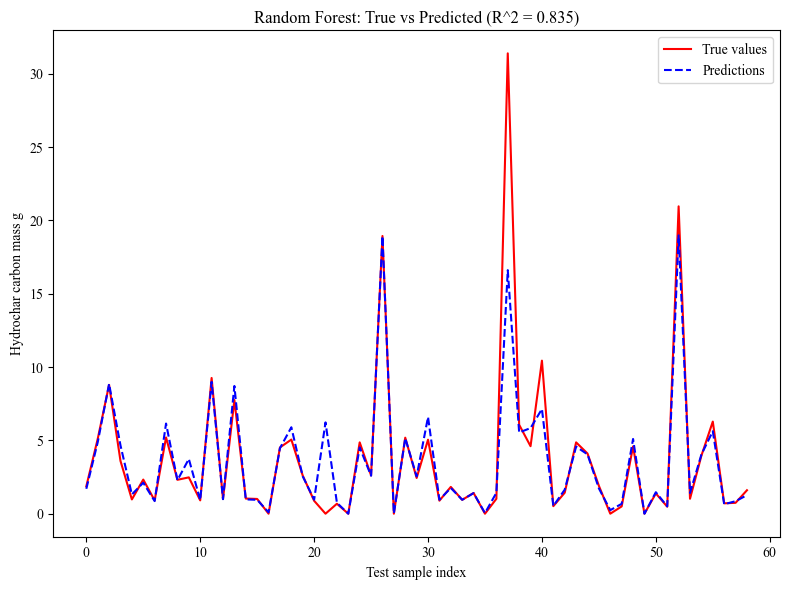

In [5]:
# Step 5 — True vs Predicted plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(y_test)), y_test, "r-", label="True values")
plt.plot(np.arange(len(y_pred)), y_pred, "b--", label="Predictions")
plt.legend()
plt.xlabel("Test sample index")
plt.ylabel("Hydrochar carbon mass g")
plt.title(f"Random Forest: True vs Predicted (R^2 = {R2:.3f})")
plt.tight_layout()
plt.show()


In [6]:
# Step 6 — Repeat training multiple times to find best RF model
index_big = {}
number = 30
best_r2 = -np.inf
best_model_data = None

for i in range(number):
    print(f"Iteration: {i+1}/{number}")
    
    X_train_i, X_test_i, y_train_i, y_test_i, train_idx_i, test_idx_i, f_names_i, orig_i, scaler_i = preprocess_data(data)
    
    model_i = build_model(n_estimators=n_estimators, max_depth=max_depth)
    model_i.fit(X_train_i, y_train_i)
    y_pred_i = model_i.predict(X_test_i)
    
    MAE_i, MSE_i, RMSE_i, R2_i = evaluate_model(y_test_i, y_pred_i)
    index_big[i] = [MAE_i, MSE_i, RMSE_i, R2_i]
    
    # Track best model
    if R2_i > best_r2:
        best_r2 = R2_i
        best_model_data = (i, train_idx_i, test_idx_i, f_names_i, model_i, orig_i, scaler_i, X_train_i, X_test_i, y_train_i, y_test_i)

# Convert to DataFrame
df_metrics = pd.DataFrame(index_big, index=["MAE", "MSE", "RMSE", "R2"]).T
now = datetime.datetime.now().strftime("%Y%m%d%H%M")
result_file = f"rf_results_{now}.xlsx"
df_metrics.to_excel(result_file, index=True)
print("Saved metrics to:", os.path.abspath(result_file))

display(df_metrics.describe())


Iteration: 1/30
Iteration: 2/30
Iteration: 3/30
Iteration: 4/30
Iteration: 5/30
Iteration: 6/30
Iteration: 7/30
Iteration: 8/30
Iteration: 9/30
Iteration: 10/30
Iteration: 11/30
Iteration: 12/30
Iteration: 13/30
Iteration: 14/30
Iteration: 15/30
Iteration: 16/30
Iteration: 17/30
Iteration: 18/30
Iteration: 19/30
Iteration: 20/30
Iteration: 21/30
Iteration: 22/30
Iteration: 23/30
Iteration: 24/30
Iteration: 25/30
Iteration: 26/30
Iteration: 27/30
Iteration: 28/30
Iteration: 29/30
Iteration: 30/30
Saved metrics to: C:\Users\check\OneDrive - Kentucky State University\Python Learning\rf_results_202511240147.xlsx


,MAE,MSE,RMSE,R2
count,30.000000,30.000000,30.000000,30.000000
mean,0.440094,1.476662,1.091036,0.929719
std,0.126974,1.527498,0.544220,0.042122
min,0.253826,0.209366,0.457565,0.826136
25%,0.344807,0.501504,0.707999,0.907056
50%,0.417684,0.865298,0.930204,0.940498
75%,0.508581,1.468905,1.211433,0.960354
max,0.806075,5.333002,2.309329,0.985412


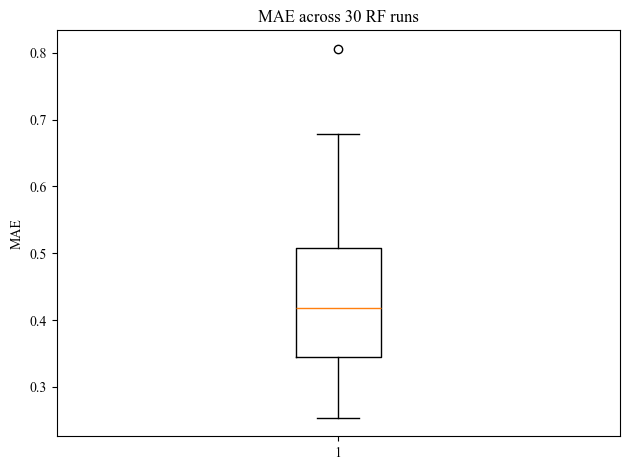

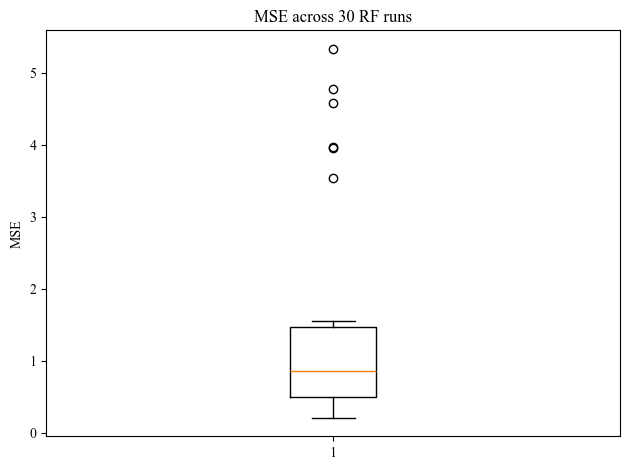

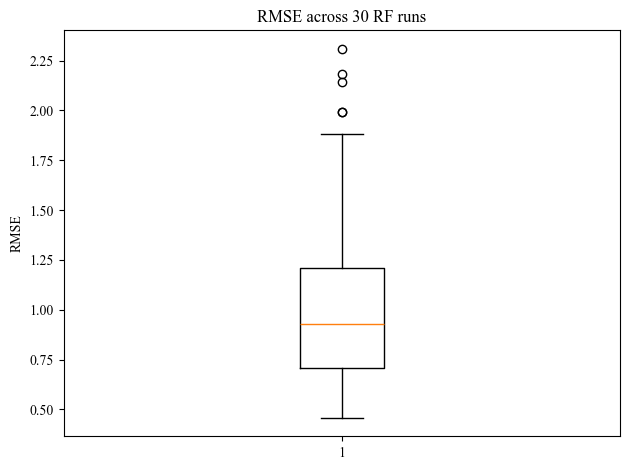

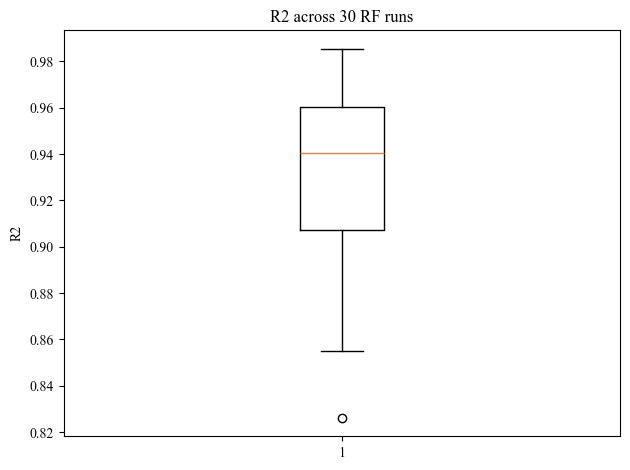

In [7]:
# Step 7 — Boxplots of metrics across runs
labels = ["MAE", "MSE", "RMSE", "R2"]

for label in labels:
    plt.figure()
    plt.boxplot(df_metrics[label].values)
    plt.title(f"{label} across {len(df_metrics)} RF runs")
    plt.ylabel(label)
    plt.tight_layout()
    plt.show()


Best model at iteration 28 with R^2 = 0.9854


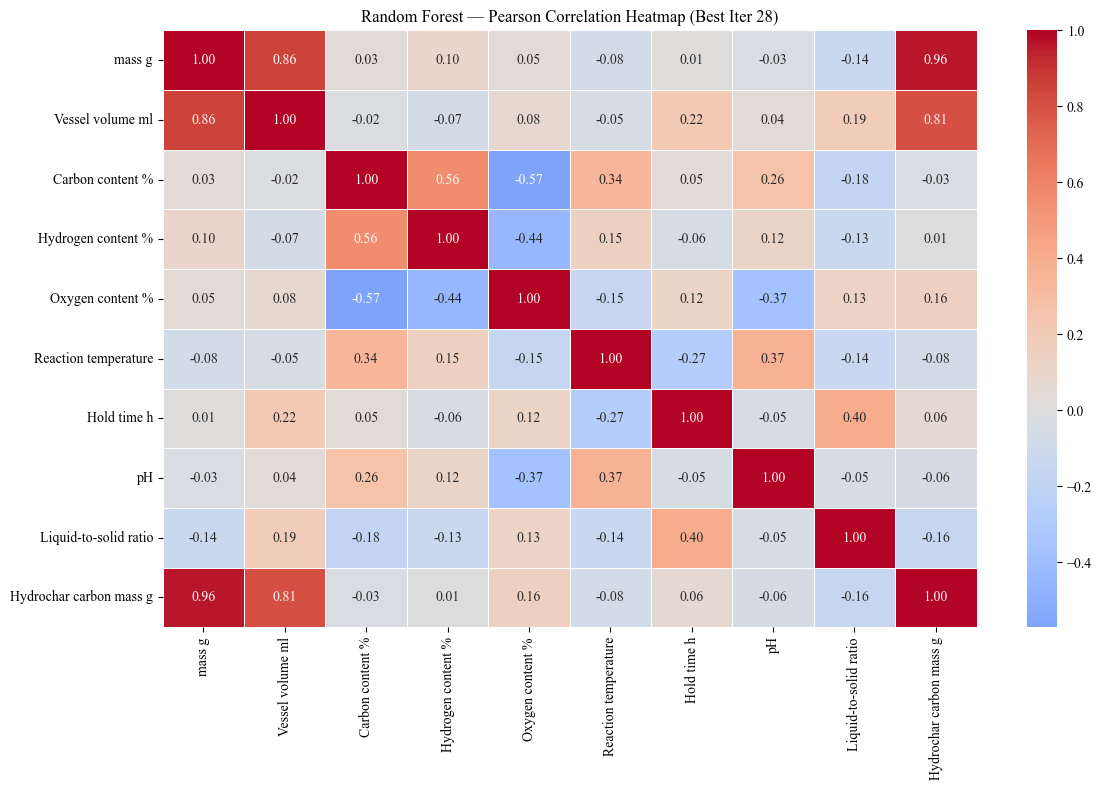

In [8]:
# Step 8 — Pearson correlation heatmap for best RF model
if best_model_data is not None:
    best_i, best_train_idx, best_test_idx, best_feature_names, best_model, best_original_data, best_scaler, best_X_train, best_X_test, best_y_train, best_y_test = best_model_data
    
    print(f"Best model at iteration {best_i+1} with R^2 = {best_r2:.4f}")
    
    test_df = best_original_data.loc[best_test_idx].copy()
    # include target explicitly
    corr_cols = best_feature_names.tolist() + ["Hydrochar carbon mass g"]
    corr_matrix = test_df[corr_cols].corr(method='pearson')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
    plt.title(f"Random Forest — Pearson Correlation Heatmap (Best Iter {best_i+1})")
    plt.tight_layout()
    plt.show()


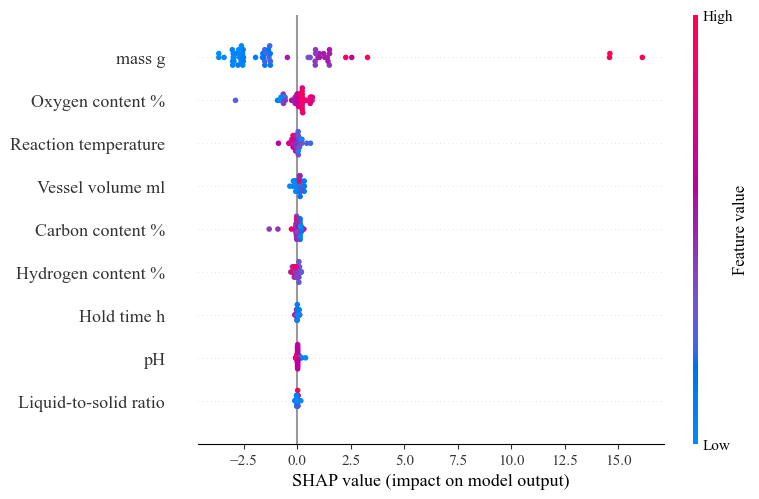

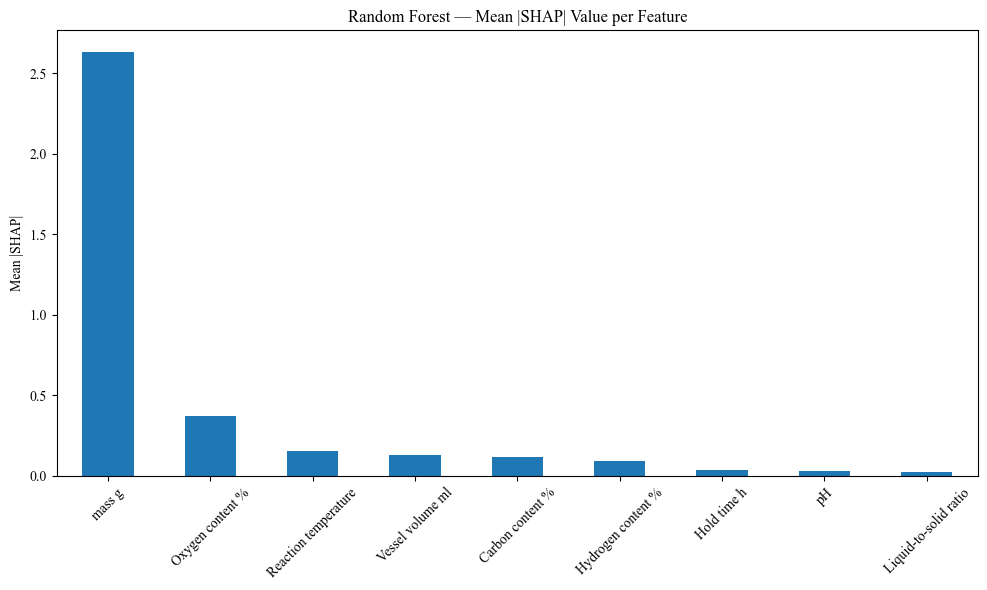

In [9]:
# Step 9 — SHAP analysis for best RF model
def run_shap_tree(model, X, feature_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    # Summary plot (beeswarm)
    shap.summary_plot(shap_values, X, feature_names=feature_names)

    # Mean |SHAP| bar plot
    shap_mean_values = np.mean(np.abs(shap_values), axis=0)
    shap_mean_df = pd.DataFrame(shap_mean_values, index=feature_names, columns=["Mean SHAP Value"])
    shap_mean_df.sort_values(by="Mean SHAP Value", ascending=False, inplace=True)
    
    plt.figure(figsize=(10, 6))
    shap_mean_df["Mean SHAP Value"].plot(kind="bar")
    plt.title("Random Forest — Mean |SHAP| Value per Feature")
    plt.ylabel("Mean |SHAP|")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if best_model_data is not None:
    # Use scaled test inputs for SHAP (X array)
    X_shap = best_X_test
    run_shap_tree(best_model, X_shap, best_feature_names)
